<a href="https://colab.research.google.com/github/blackBagel/Sarcasm-Detection-Learn/blob/main/sarcasm_detection_simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
! pip install -U eli5 clean-text

Requirement already up-to-date: eli5 in /usr/local/lib/python3.6/dist-packages (0.10.1)
Requirement already up-to-date: clean-text in /usr/local/lib/python3.6/dist-packages (0.3.0)


In [59]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
import spacy
import re
from cleantext import clean
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import eli5
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [60]:
DRIVE_PATH = '/gdrive/My Drive/Reddit sarcasm'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [61]:
DATA_COLUMNS = [
    'label',
    'comment',
    'author',
    'subreddit',
    'score',
    'ups',
    'downs',
    'date',
    'created_utc',
    'parent_comment'
]

full_comments_df = pd.read_csv("train-balanced-sarc.csv", delimiter='\t', names=DATA_COLUMNS)

## Methodology

First, let's see the data distributions

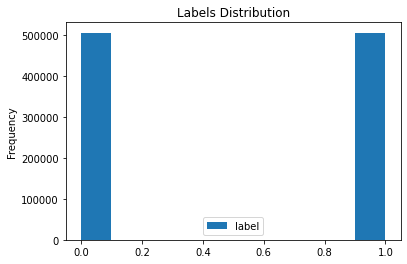

In [62]:
full_comments_df.plot(kind='hist', y='label', title = 'Labels Distribution')

The data is balanced with regard to the labels. Therefore, I'll use the accuracy metric to evaluate all future models.

I prefer to evaluate all the models based primarily on accuracy. The data is well balanced and there is no actual buisiness problem i'm solving here, so there's not much of a need to specifically avoid either FPs or FNs.

I will however keep the precision and recall scores of all models for future reference

#### Train-Validation-Test Split 

The dataset is quite relatively large with about 1 million comments. For that reason, it is quite reasonable to use only 4% of the data as test and validation sets, since they'll still be 20k each.

That way, we'll have lots of data to train on.

In [63]:
TRAIN_TEST_RAND_STATE = 1
VAL_TEST_RAND_STATE = 5
TRAIN_TEST_SPLIT = 0.04
VAL_TEST_SPLIT = 0.5

comments_df_without_labels = full_comments_df.iloc[:, 1:]

# We use the same train-test split to test all of the next models
df_train, df_test, labels_train, labels_test = train_test_split(comments_df_without_labels,
                                                                full_comments_df['label'],
                                                                random_state=TRAIN_TEST_RAND_STATE,
                                                                test_size=TRAIN_TEST_SPLIT,
                                                                shuffle=True)

df_val, df_test, labels_val, labels_test = train_test_split(df_test,
                                                            labels_test,
                                                            random_state=VAL_TEST_RAND_STATE,
                                                            test_size=VAL_TEST_SPLIT,
                                                            shuffle=True)

Let's make sure the validation and test set have similar distributions

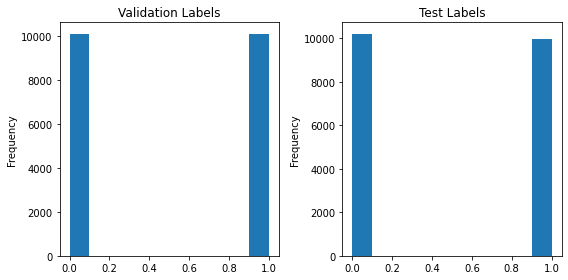

In [64]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

labels_val.plot.hist(ax = axes[0], title='Validation Labels')
labels_test.plot.hist(ax = axes[1], title='Test Labels')
fig.tight_layout()

#### Null handling

In [65]:
print("Nulls in training set:")
df_train.isnull().sum()

Nulls in training set:


comment           51
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Since I don't want to divide and reassemble the data and the labels each time i apply a function to both, i'll simply create a function that applies row based functions to them and handles the dividing and reassembling for me

In [66]:
def handle_row_dropping_functions(df, labels, row_dropping_funcs={}):
  """
  Applies data munging functions that may drop rows in the dataset
  This function makes sure the corresponding labels of each dropped row is deleted as well

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to apply the functions on
  labels : pandas Series
      The corresponding labels of the dataset
  row_dropping_funcs : Dict
      A dictionary containing functions as keys
      and any parameters necessary for them (except the df!) as values

  Returns
  -------
  new_df
      The recieved DF after being handled the fucntions
  new_labels:
      The labels for the df, without the dropped rows
  """

  # Combine data and labels based on their index
  new_df = df.copy()
  new_labels = labels.copy()
  new_df['label'] = new_labels
  
  # Apply row dropping functions
  for row_dropping_func, func_params in row_dropping_funcs.items():
    func_params['df'] = new_df
    new_df = row_dropping_func(**func_params)
  
  # Return the updated datasets as they were before
  new_labels = new_df['label']
  new_df = new_df.drop(columns = ['label'])

  return new_df, new_labels

In [67]:
def handle_nulls(**kwargs):
  """
  Returns the df without rows where some columns are null
  Right now could have been done without a function,
  but useful for encapsulating more complex null handling situations in the future

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to drop NaNs from
  unfixable_columns : list
      The columns that need to be dropped if empty (default is an empty list)

  Returns
  -------
  new_df
      The recieved DF but with rows without null columns
  """

  new_df = kwargs['df'].copy()
  new_df = new_df.dropna(subset = kwargs['unfixable_columns'])
  return new_df

In [68]:
def nan_handle(df, labels):
  new_df = df.copy()
  new_labels = labels.copy()

  # If the value of these columns is null, drop the row 
  COLUMNS_TO_DROP_BY = ['comment']

  row_dropping_funcs = {
      handle_nulls: { 'unfixable_columns': COLUMNS_TO_DROP_BY }
      }

  new_df, new_labels = handle_row_dropping_functions(new_df, new_labels, row_dropping_funcs)
  return new_df, new_labels

#### Text cleaning - Comments only

For starters, i'll only explore the comments themselves to see how much sarcasm can be inferred from the text alone.

Later on i'll start engineering more features from the rest of the data to see how much the context matters for inferring sarcasm with this data

Let's look at a sample from the text to see what we're handling with

In [69]:
for index, text in enumerate(df_train['comment'][35:40]):
  print('Comment {}:\n {}'.format(index+1, text))

Comment 1:
 That Stormtrooper pumpkin looks awesome!
Comment 2:
 Yeah, Barry will let this slide.
Comment 3:
 Uh oh, Trigga Trey gonna get some revenge.
Comment 4:
 fuck your opinion
Comment 5:
 we know, but not to loud or the wackos will catch on


In [70]:
NLP_ENGINES = {
    'simple' : spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner']),
    'POSs_and_deps' : spacy.load("en_core_web_sm", disable=['ner'])
}

In [71]:
def tokenize_and_clean_text(doc):
  tokenized_processed_text = []
  for token in doc: 
    cleaned_text = token.text.lower()
    if token.is_currency:
      cleaned_text = clean(cleaned_text, no_currency_symbols = True)
    if token.like_email:
      cleaned_text = clean(cleaned_text, no_emails = True)
    if token.like_url:
      cleaned_text = clean(cleaned_text, no_urls = True)
    
    tokenized_processed_text.append(cleaned_text)
  
  return tokenized_processed_text

###### Simple text cleaning and tokenization

In [72]:
def simple_single_text_processing(text):
  # spaCy does not handle numbers without text well, so we'll clean them in  the beginning
  clean(text, no_numbers=True)
  
  # spaCy will only handle contractions and will just tokenize the data in general
  nlp_engine = NLP_ENGINES['simple']
  doc = nlp_engine(text)

  list_of_processed_tokens = tokenize_and_clean_text(doc)
  return ' '.join(list_of_processed_tokens)

In [73]:
def simple_text_processing(df, text_columns='comment'):
  new_fd = df.copy()
  for column in text_columns:
    new_df['processed ' + column] = new_df[column].apply(lambda text: simple_single_text_processing(text))
  return new_df

##### More advanced text features

In order to process text for more advanced features, we'll use spacy's ready pipelines. But considering the fact we're dealing with 1M comments, it's worth trying to parallelize the workload

We'll do a few quick checks to see what are roughly the right parameters to run this parallelized processing

In [74]:
! lscpu | grep CPU\(s\)

CPU(s):              2
On-line CPU(s) list: 0,1
NUMA node0 CPU(s):   0,1


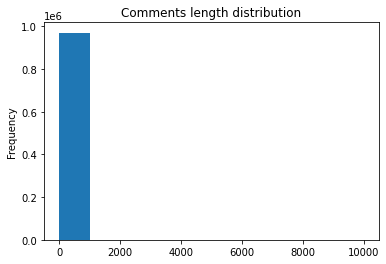

In [75]:
# Since there's a few comments that are just numbers and no text, we'll convert all comments to string just in case
comment_length = df_train['comment'].apply(lambda text: len(str(text)))
comment_length.plot(kind='hist', y='comment length', title = 'Comments length distribution')

Not surprisingly, most of the comments are pretty short. Let's see how many of them are actually huge

In [76]:
comment_length.describe()

count    970392.000000
mean         56.691743
std          62.433983
min           1.000000
25%          27.000000
50%          46.000000
75%          74.000000
max       10000.000000
Name: comment, dtype: float64

In [77]:
long_comment_mask = comment_length > 200
print('Overall ratio of long comments: %.3f' % (long_comment_mask.mean()))

Overall ratio of long comments: 0.011


Well, because there are about 1% long comments, can use a large chunk size and pipe size since for every 100K comments i'll only get 1000 long comments, which is nothing compared to the amount of RAM i have

In [85]:
def chunker(iterable, total_length, chunksize):
    return [iterable[position: position + chunksize] for position in range(0, total_length, chunksize)]

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    new_columns = []
    nlp_engine = NLP_ENGINES['POSs_and_deps']
    
    clean_texts = [clean(text, no_numbers=True) for text in texts]
    for doc in nlp_engine.pipe(clean_texts, batch_size=20000):
      features = {}

      features['pos tags'] = ' '.join([token.tag_.lower() for token in doc])
      features['word dependencies'] = ' '.join([token.dep_.lower() for token in doc])

      # I'll also keep a simple tokenized version of the text since there's no reason to run spacy twice 
      features['processed comment'] = ' '.join(tokenize_and_clean_text(doc))

      new_columns.append(features)

    return new_columns

def parallel_pos_and_dep_text_processing(texts, chunksize):
    executor = Parallel(n_jobs=-1, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = [do(chunk) for chunk in chunker(texts, len(texts), chunksize=chunksize)]
    result = executor(tasks)
    new_columns = flatten(result)
    return pd.DataFrame(new_columns)

def pos_and_dep_text_processing(df, text_columns='comment'):
  new_df = df.copy()
  for column in text_columns:
    advanced_df_features = parallel_pos_and_dep_text_processing(new_df[column], chunksize=100000)
    advanced_df_features.index = new_df.index
    new_df = new_df.merge(advanced_df_features, how='left', left_index=True, right_index=True)

  return new_df

For chunk size of 100K and pipe size of 20K it took 16min and 22s

In [86]:
def get_advanced_text_columns(df, processing_type='simple', from_where='scratch', file_path=None):
  new_df = df.copy()
  if file_path is not None:
    if from_where == 'scratch':
      if processing_type == 'simple':
        new_df = simple_text_processing(new_df, text_columns=['comment'])
      elif processing_type == 'pos_and_deps':
        new_df = pos_and_dep_text_processing(new_df, text_columns=['comment'])
        
      new_df.to_csv(file_path)

    elif from_where == 'file':
      new_df_processed = pd.read_csv(file_path)
      new_df_processed.index = new_df.index
      new_df = new_df.merge(new_df_processed, how='left', left_index = True, right_index = True) 
    else:
      print('You haven\'t entered a valid file path')

  return new_df

In [87]:
def preprocess_df(df, labels, processing_type, extra_features_from, extra_features_file_path):
  new_df = df.copy()
  new_labels = labels.copy()  

  new_df, new_labels = nan_handle(new_df, new_labels)

  new_df = get_advanced_text_columns(new_df,
                                     processing_type = processing_type,
                                     from_where = extra_features_from,
                                     file_path = extra_features_file_path)

  return new_df, new_labels

In [88]:
full_df_train_for_clf, labels_train_for_clf = preprocess_df(df_train, labels_train,
                                                            processing_type = 'pos_and_deps',
                                                            extra_features_from = 'file',
                                                            extra_features_file_path = 'train_with_POSs_and_deps_rand_state_{}.csv'.format(TRAIN_TEST_RAND_STATE))

In [89]:
for index, text in enumerate(full_df_train_for_clf['processed comment'][35:40]):
  print('Comment {}:\n {}'.format(index+1, text))

Comment 1:
 that stormtrooper pumpkin looks awesome !
Comment 2:
 yeah , barry will let this slide .
Comment 3:
 uh oh , trigga trey gon na get some revenge .
Comment 4:
 fuck your opinion
Comment 5:
 we know , but not to loud or the wackos will catch on


# Model Research Process - Comments Only

#### Preprocess the validation and test datasets

In [97]:
full_df_val_for_clf, labels_val_for_clf = preprocess_df(df_val, labels_val,
                                                        processing_type = 'pos_and_deps',
                                                        extra_features_from = 'file',
                                                        extra_features_file_path = 'validation_with_POSs_and_deps_rand_state_{}.csv'.format(VAL_TEST_RAND_STATE))
full_df_test_for_clf, labels_test_for_clf = preprocess_df(df_test, labels_test,
                                                          processing_type = 'pos_and_deps',
                                                          extra_features_from = 'file',
                                                          extra_features_file_path = 'test_with_POSs_and_deps_rand_state_{}.csv'.format(VAL_TEST_RAND_STATE))

## We begin our research by trying out a basic logistic regression model on only a simple tokenized comment

In [25]:
FEATURES_TO_CLASSIFY_BY = ['processed comment']
df_train_for_clf = full_df_train_for_clf[FEATURES_TO_CLASSIFY_BY]
df_val_for_clf = full_df_val_for_clf[FEATURES_TO_CLASSIFY_BY]
df_test_for_clf = full_df_test_for_clf[FEATURES_TO_CLASSIFY_BY]

In [26]:
TEXTUAL_COLUMNS = 'processed comment'
model_pipes_to_evaluate = {}
MODELS_FOLDER = './models'

In [ ]:
def save_model_pipeline_and_info(model_pipe_and_info, file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  with open(full_path, 'wb') as model_pipeline_and_info_file:
    pickle.dump(model_pipe_and_info, model_pipeline_and_info_file)
            
def get_model_pipeline_and_info(file_name):
  full_path = os.path.join(MODELS_FOLDER, file_name)
  if os.path.exists(full_path):
    with open(full_path, 'rb') as model_pipeline_and_info_file:
      model_pipe_and_info = pickle.load(model_pipeline_and_info_file)
  else:
      return None
  return model_pipe_and_info

### First, a relatively primitive count vectorizer of the comments

In [ ]:
# I'll assume a word that doesn't appear at least thrice, is probably too specific to care about
ctv = CountVectorizer(min_df = 3)
text_preprocessor = ColumnTransformer(
    transformers=[
        ('text', ctv, TEXTUAL_COLUMNS)
    ])
log_reg_ctv_clf = LogisticRegression(solver='saga', C=1, n_jobs=-1, verbose=False, max_iter=300)
ctv_lr_pipeline = Pipeline([('counter', text_preprocessor), 
                            ('logitRegressor', log_reg_ctv_clf)])

In [ ]:
%%time
ctv_lr_pipeline.fit(df_train_for_clf, labels_train_for_clf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 6min 6s, sys: 359 ms, total: 6min 6s
Wall time: 4min 41s


Pipeline(memory=None,
         steps=[('counter',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('text',
                                                  CountVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.int64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                                  

In [ ]:
# Logistic Regressor has a ready score function that returns the accuracy of the model on another dataset
print ("Training accuracy: %0.5f " % ctv_lr_pipeline.score(df_train_for_clf, labels_train_for_clf))
print ("Validation accuracy: %0.5f " % ctv_lr_pipeline.score(df_val_for_clf, labels_val_for_clf))

Training accuracy: 0.64346 
Validation accuracy: 0.63717 


### We also test a basic tf-idf vector

In [ ]:
# We'll first try to create a simple baseline model
# Our baseline model will be a logistic regression model, which we'll train on the unigram tf_idf vectors of the original comments text 
tfv = TfidfVectorizer(min_df = 3)
text_preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfv, TEXTUAL_COLUMNS)
    ])
lr_tfidf_clf = LogisticRegression(solver='saga', n_jobs=-1, verbose=False, max_iter=300)

tfidf_lr_pipeline = Pipeline([('tf_idf', text_preprocessor), 
                                 ('logitRegressor', lr_tfidf_clf)])

In [ ]:
%%time
tfidf_lr_pipeline.fit(df_train_for_clf, labels_train_for_clf)

CPU times: user 34.6 s, sys: 28 ms, total: 34.7 s
Wall time: 34.7 s


Pipeline(memory=None,
         steps=[('tf_idf',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                                 

In [ ]:
print ("Training accuracy: %0.5f " % tfidf_lr_pipeline.score(df_train_for_clf, labels_train_for_clf))
print ("Validation accuracy: %0.5f " % tfidf_lr_pipeline.score(df_val_for_clf, labels_val_for_clf))

Training accuracy: 0.71713 
Validation accuracy: 0.69158 


### We try a more sophisticated tf-idf vector

In [27]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
text_preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfv, TEXTUAL_COLUMNS)
    ])
lr_tfidf_clf = LogisticRegression(solver='saga', n_jobs=-1, verbose=False, max_iter=300)

tfidf_lr_pipeline = Pipeline([('tf_idf', text_preprocessor), 
                              ('logitRegressor', lr_tfidf_clf)])

In [ ]:
%%time
tfidf_lr_pipeline.fit(df_train_for_clf, labels_train_for_clf)

CPU times: user 1min 13s, sys: 850 ms, total: 1min 14s
Wall time: 1min 14s


Pipeline(memory=None,
         steps=[('tf_idf',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                                 

In [ ]:
print ("Training accuracy: %0.5f " % tfidf_lr_pipeline.score(df_train_for_clf, labels_train_for_clf))
print ("Validation accuracy: %0.5f " % tfidf_lr_pipeline.score(df_val_for_clf, labels_val_for_clf))

Training accuracy: 0.78497 
Validation accuracy: 0.72373 


In [ ]:
# Because it was te best model we tried to understand better what affected his performance
eli5.show_weights(estimator=tfidf_lr_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_lr_pipeline.named_steps['tf_idf'])

Weight?,Feature
+10.494,text__yes because
+8.981,text__obviously
+8.798,text__clearly
+8.336,text__totally
+8.335,text__yeah because
+8.237,text__because
+6.903,text__how dare
+6.356,text__good thing
+6.100,text__right because
+5.725,text__gee


So using tf-idf with bi-grams and a minimum df count of 3 seems to be a good representation for the data for now.

Later on i'll try to use embeddings too and see if they add any significant gains

#### Let's save this model as the best one for now, and move on to more sophisticated classifiers

In [56]:
scores = {
  'Training' : 0.78497,
  'Validation' : 0.72373,
  'Test' : 0.72621 # Calculated this on another run
}
best_model_so_far = {
    'name' : 'tf-idf bi-gram min-df-3 logit-regressor', # Name of the model
    'pipeline_and_params' : (tfidf_lr_pipeline, {}), # A tuple containing a sklearn.Pipeline object and a parameters dict
    'scores' : scores, # A dict of scores on each dataset
    'time' : 74 # Training time in seconds
}

In [63]:
save_model_pipeline_and_info(best_model_so_far, file_name='best_model_so_far.pickle')

## Using better Classifiers on a Bi-Gram Tf-Idf with min_df of 3

In [ ]:
old_best_model_so_far = get_model_pipeline_and_info(file_name='best_model_so_far.pickle')
best_model_so_far = dict(old_best_model_so_far)

In [ ]:
ACCURACY_IMPROVEMENT_MARGIN = 0.03

def is_model_fame_worthy(scores):
  global best_model_so_far
  return scores['Test'] >= (best_model_so_far['scores']['Test'] + ACCURACY_IMPROVEMENT_MARGIN)

dict_of_fame = {
    old_best_model_so_far['name'] : old_best_model_so_far['scores']
    }

In [ ]:
def evaluate_model_pipelines(model_pipelines):
  for name, (model_pipeline, fit_params) in model_pipelines.items():
    print('\n###########################################################################')
    print('# Model type: {}'.format(name))
    print('###########################################################################')
    
    # Train the model
    fit_start = perf_counter()
    model_pipeline.fit(df_train_for_clf, labels_train_for_clf, **fit_params)
    fit_end = perf_counter()

    # plot_model_performance(model_history)
    
    # Calculate the current model's performance and time
    # fit time is in seconds
    fit_time = fit_end - fit_start
    fit_time_hours = int(fit_time / 60 / 60)
    fit_time_minutes = int(fit_time / 60 )
    fit_time_seconds = int(fit_time % 60)

    print("Training time: {} hours, {} minutes, {} seconds".format(fit_time_hours, fit_time_minutes, fit_time_seconds))

    train_predictions = model_pipeline.predict(df_train_for_clf)
    val_predictions = model_pipeline.predict(df_val_for_clf)
    test_predictions = model_pipeline.predict(df_test_for_clf)

    scores = {
        'Training' : accuracy_score(labels_train_for_clf, train_predictions),
        'Validation' : accuracy_score(labels_val_for_clf, val_predictions),
        'Test' : accuracy_score(labels_test_for_clf, test_predictions)
        }
    for dataset_name, score in scores.items():
      print ("%s accuracy: %0.5f " % (dataset_name, score))

    if is_model_fame_worthy(scores):
      global best_model_so_far
      best_model_so_far = {
          'name' : name, # Name of the model
          'pipeline_and_params' : (model_pipeline, fit_params), # A tuple containing a sklearn.Pipeline object and a parameters dict
          'scores' : scores, # A dict of scores on each dataset
          'time' : fit_time # Training time in seconds
          }
      dict_of_fame[name] = scores

  print('\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  print('@ Best models roundup')
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  for name, score in dict_of_fame.items():
    print(f'Name: {name}\n Scores: {score}')

#### Classifiers

In [ ]:
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
text_preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfv, TEXTUAL_COLUMNS)
    ])

# XGB and LightGBM common extra parameters
text_preprocessor_for_fancy_clfs = ColumnTransformer(
    transformers=[('Text', Pipeline([
                                    ('tf-idf', tfv),
                                    ('svd', TruncatedSVD(algorithm='randomized', n_components=700))
                                    ]),
                   TEXTUAL_COLUMNS
                   )]
    )

EVAL_METRIC = 'logloss'

# XGBoost and the like expect only numbers
# So we'll convert the validation set in advance so we could use it for early stopping
text_preprocessor_for_fancy_clfs.fit(df_train_for_clf)
df_val_for_gb_clfs = text_preprocessor_for_fancy_clfs.transform(df_val_for_clf)

EARLY_STOP_EVAL_SET = [(df_val_for_gb_clfs, labels_val_for_clf)]

##### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', max_iter=400)
fit_params = {}

svc_pipeline = Pipeline([('tf_idf', text_preprocessor), 
                         ('SVM Classifer', svc)])

model_pipes_to_evaluate['SVM Classifer with best tf-idf'] = (svc_pipeline, dict(fit_params))

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rand_f = RandomForestClassifier(n_estimators=1000, n_jobs = -1)
fit_params = {}

rand_f_pipeline = Pipeline([('tf_idf', text_preprocessor), 
                         ('rand_forest', rand_f)])

model_pipes_to_evaluate['Random Forest with best tf-idf'] = (rand_f_pipeline, dict(fit_params))

##### XGBoost

In [ ]:
xgbc = XGBClassifier(objective = 'binary:logistic',
                     n_estimators = 1000,
                     learning_rate = 0.01,
                     n_jobs = -1,
                     tree_method = 'gpu_hist')

model_name = 'xgboost'
fit_params = {
    model_name + '__early_stopping_rounds' : 20,
    model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

xgb_pipeline = Pipeline([('tf_idf', text_preprocessor_for_fancy_clfs), 
                         (model_name, xgbc)])
model_pipes_to_evaluate['XGBRegressor with best tf-idf'] = (xgb_pipeline, dict(fit_params))

##### LightGBM

In [ ]:
lgbc = LGBMClassifier(n_estimators=1000, n_jobs = -1, objective = 'binary')

model_name = 'LightGBM'
fit_params = {
    model_name + '__early_stopping_rounds' : 20,
    model_name + '__eval_set' : EARLY_STOP_EVAL_SET, 
    model_name + '__eval_metric' : EVAL_METRIC,
    model_name + '__verbose' : False
}

lgbc_pipeline = Pipeline([('tf_idf', text_preprocessor_for_fancy_clfs), 
                         (model_name, lgbc)])
model_pipes_to_evaluate['LightGBM with best tf-idf'] = (lgbc_pipeline, dict(fit_params))

#### And for the results:

In [ ]:
evaluate_model_pipelines(model_pipes_to_evaluate)


###########################################################################
# Model type: SVM Classifer with best tf-idf
###########################################################################
Training time: 0 hours, 0 minutes, 0 seconds
Training accuracy: 0.95000 
Validation accuracy: 0.90000 
Test accuracy: 0.90000 

###########################################################################
# Model type: Random Forest with best tf-idf
###########################################################################
Training time: 0 hours, 0 minutes, 1 seconds
Training accuracy: 1.00000 
Validation accuracy: 0.90000 
Test accuracy: 0.90000 

###########################################################################
# Model type: XGBRegressor with best tf-idf
###########################################################################
Training time: 0 hours, 0 minutes, 0 seconds
Training accuracy: 0.95000 
Validation accuracy: 0.90000 
Test accuracy: 0.90000 

#########################

In [ ]:
best_model_so_far

{'name': 'SVM Classifer with best tf-idf',
 'pipeline_and_params': (Pipeline(memory=None,
           steps=[('tf_idf',
                   ColumnTransformer(n_jobs=None, remainder='drop',
                                     sparse_threshold=0.3,
                                     transformer_weights=None,
                                     transformers=[('text',
                                                    TfidfVectorizer(analyzer='word',
                                                                    binary=False,
                                                                    decode_error='strict',
                                                                    dtype=<class 'numpy.float64'>,
                                                                    encoding='utf-8',
                                                                    input='content',
                                                                    lowercase=True,
                   